In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import timedelta, datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

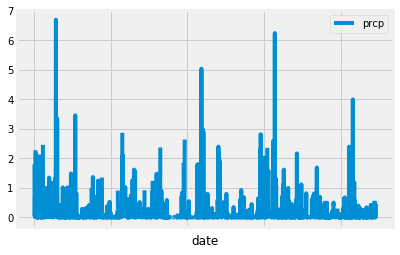

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = dt.datetime.strptime(last[0],"%Y-%m-%d").date()
first_date = last_date - timedelta(365)

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]
query = session.query(*sel).filter(Measurement.date >= first_date).filter(Measurement.date <= last_date)

# Save the query results as a Pandas DataFrame and set the index to the date column
df_prcp = pd.read_sql_query(query.statement, engine).set_index('date')

# Sort the dataframe by date
df_sorted = df_prcp.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
df_sorted.plot()

![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
stats = df_sorted.describe()
stats

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement.station).distinct('station').count()
station_count

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = session.query(Measurement.station, func.count(Measurement.station).label('count'))\
.group_by(Measurement.station)\
.order_by('count DESC').all()

stations

/Users/tkabdela/anaconda3/lib/python3.6/site-packages/sqlalchemy/sql/compiler.py:643: SAWarning: Can't resolve label reference 'count DESC'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

most_active = stations[0][0]
sel = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
temps = session.query(*sel).filter(Measurement.station == most_active).all()
temps

[(54.0, 85.0, 71.66378066378067)]

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = session.query(Measurement.tobs).filter(Measurement.station == most_active)\
.filter(Measurement.date >= first_date)
df_temps = pd.read_sql_query(query.statement,engine)
df_temps.head()

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


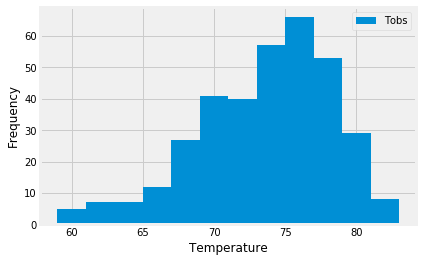

In [16]:
#create histogram
plt.hist(df_temps['tobs'],bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['Tobs'])

![precipitation](Images/station-histogram.png)

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc = calc_temps('2011-02-28','2011-03-05')
calc

[(61.0, 69.75510204081633, 75.0)]

Text(0,0.5,'Temp (F)')

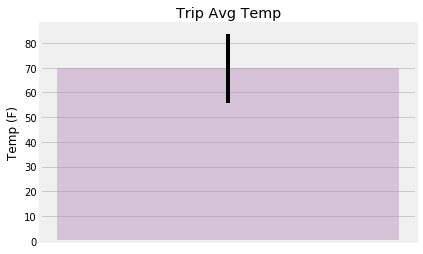

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tavg = calc[0][1]
tmax = calc[0][2]
tmin = calc[0][0]
p2p = tmax - tmin
x = len(calc)
plt.bar(x,tavg,yerr=p2p,color=(0.7,0.5,0.7,0.4))
plt.xticks(np.arange(0,1,step=1))
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Station.station,
       Station.name,
       Station.latitude,
       Station.longitude,
      Station.elevation,
      Measurement.prcp]
query = session.query(*sel).filter(Measurement.date >= first_date).filter(Measurement.date <= last_date)\
.filter(Measurement.station == Station.station).group_by(Station.station).order_by(Measurement.prcp.desc())
df_stations = pd.read_sql_query(query.statement,engine)
df_stations.set_index('name')

,station,latitude,longitude,elevation,prcp
name,,,,,
"MANOA LYON ARBO 785.2, HI US",USC00516128,21.33310,-157.80250,152.4,0.45
"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523,21.33556,-157.71139,19.5,0.08
"WAIHEE 837.5, HI US",USC00519281,21.45167,-157.84889,32.9,0.06
"KANEOHE 838.1, HI US",USC00513117,21.42340,-157.80150,14.6,0.00
"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830,21.52130,-157.83740,7.0,0.00
"WAIKIKI 717.2, HI US",USC00519397,21.27160,-157.81680,3.0,0.00
"PEARL CITY, HI US",USC00517948,21.39340,-157.97510,11.9,NaN


## Optional Challenge Assignment

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [24]:
# Plot the daily normals as an area plot with `stacked=False`
